# Low-light image enhancement using MIRNet


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Downloading LOLDataset

The **LoL Dataset** has been created for low-light image enhancement.
It provides 485 images for training and 15 for testing. Each image pair in the dataset
consists of a low-light input image and its corresponding well-exposed reference image.

In [2]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# %cd "/content/drive/MyDrive/EE610"

In [4]:
# #!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
# !unzip -q lol_dataset.zip

In [5]:
# !mkdir "checkpoint"

## Creating a TensorFlow Dataset

We use 400 image pairs from the LoL Dataset's training set for training,
and we use the remaining 85 image pairs for validation.
We generate random crops of size `64 x 64` from the image pairs to be
used for both training and validation.

In [6]:
random.seed(10)

IMAGE_SIZE = 64
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 400


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, None, None, 3), (4, None, None, 3)), types: (tf.float32, tf.float32)>


## MIRNet Model

### Selective Kernel Feature Fusion

In [7]:

# def selective_kernel_feature_fusion(
#     multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
# ):
#     channels = list(multi_scale_feature_1.shape)[-1]
#     combined_feature = layers.Add()(
#         [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
#     )
#     gap = layers.GlobalAveragePooling2D()(combined_feature)
#     channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
#     compact_feature_representation = layers.Conv2D(
#         filters=channels // 8, kernel_size=(1, 1), activation="relu"
#     )(channel_wise_statistics)
#     feature_descriptor_1 = layers.Conv2D(
#         channels, kernel_size=(1, 1), activation="softmax"
#     )(compact_feature_representation)
#     feature_descriptor_2 = layers.Conv2D(
#         channels, kernel_size=(1, 1), activation="softmax"
#     )(compact_feature_representation)
#     feature_descriptor_3 = layers.Conv2D(
#         channels, kernel_size=(1, 1), activation="softmax"
#     )(compact_feature_representation)
#     feature_1 = multi_scale_feature_1 * feature_descriptor_1
#     feature_2 = multi_scale_feature_2 * feature_descriptor_2
#     feature_3 = multi_scale_feature_3 * feature_descriptor_3
#     aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
#     return aggregated_feature

def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3, multi_scale_feature_4
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3, multi_scale_feature_4]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_4 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    feature_4 = multi_scale_feature_4 * feature_descriptor_4
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3, feature_4])
    return aggregated_feature


### Dual Attention Unit



In [8]:

def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])


### Multi-Scale Residual Block

In [9]:
# Recursive Residual Modules


# def down_sampling_module(input_tensor):
#     channels = list(input_tensor.shape)[-1]
#     main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
#         input_tensor
#     )
#     main_branch = layers.Conv2D(
#         channels, kernel_size=(3, 3), padding="same", activation="relu"
#     )(main_branch)
#     main_branch = layers.MaxPooling2D()(main_branch)
#     main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
#     skip_branch = layers.MaxPooling2D()(input_tensor)
#     skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
#     return layers.Add()([skip_branch, main_branch])

def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001),
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1), kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1), kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# def up_sampling_module(input_tensor):
#     channels = list(input_tensor.shape)[-1]
#     main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
#         input_tensor
#     )
#     main_branch = layers.Conv2D(
#         channels, kernel_size=(3, 3), padding="same", activation="relu"
#     )(main_branch)
#     main_branch = layers.UpSampling2D()(main_branch)
#     main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
#     skip_branch = layers.UpSampling2D()(input_tensor)
#     skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
#     return layers.Add()([skip_branch, main_branch])

def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001)
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1), kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1), kernel_regularizer=keras.regularizers.l1_l2(l1=0.00001, l2=0.00001))(skip_branch)
    return layers.Add()([skip_branch, main_branch])

# # MRB Block
# def multi_scale_residual_block(input_tensor, channels):
#     # features
#     level1 = input_tensor
#     level2 = down_sampling_module(input_tensor)
#     level3 = down_sampling_module(level2)
#     # DAU
#     level1_dau = dual_attention_unit_block(level1)
#     level2_dau = dual_attention_unit_block(level2)
#     level3_dau = dual_attention_unit_block(level3)
#     # SKFF
#     level1_skff = selective_kernel_feature_fusion(
#         level1_dau,
#         up_sampling_module(level2_dau),
#         up_sampling_module(up_sampling_module(level3_dau)),
#     )
#     level2_skff = selective_kernel_feature_fusion(
#         down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
#     )
#     level3_skff = selective_kernel_feature_fusion(
#         down_sampling_module(down_sampling_module(level1_dau)),
#         down_sampling_module(level2_dau),
#         level3_dau,
#     )
#     # DAU 2
#     level1_dau_2 = dual_attention_unit_block(level1_skff)
#     level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
#     level3_dau_2 = up_sampling_module(
#         up_sampling_module(dual_attention_unit_block(level3_skff))
#     )
#     # SKFF 2
#     skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
#     conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
#     return layers.Add()([input_tensor, conv])

# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    level4 = down_sampling_module(level3)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    level4_dau = dual_attention_unit_block(level4)

    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
        up_sampling_module(up_sampling_module(up_sampling_module(level4_dau))),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
        up_sampling_module(up_sampling_module(level4_dau)),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
        up_sampling_module(level4_dau),
    )
    level4_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(down_sampling_module(level1_dau))),
        down_sampling_module(down_sampling_module(level2_dau)),
        down_sampling_module(level3_dau),
        level4_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    level4_dau_2 = up_sampling_module(
        up_sampling_module(
            up_sampling_module(dual_attention_unit_block(level4_skff))
    )
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2, level4_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])


### MIRNet Model

In [10]:

def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=32)

## Training

In [13]:

def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image


### Inference on Test Images

We compare the test images from LOLDataset enhanced by MIRNet with images
enhanced via the `PIL.ImageOps.autocontrast()` function.

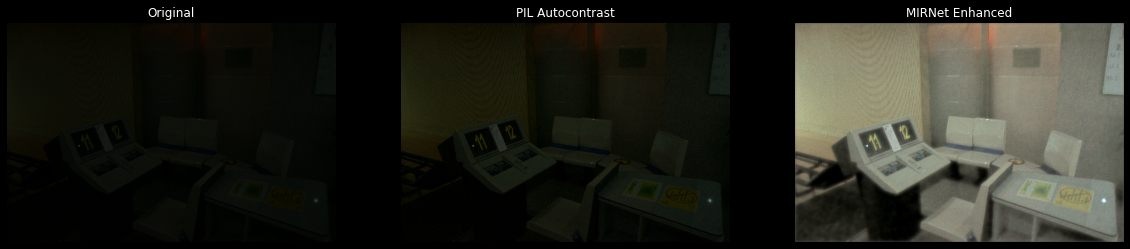

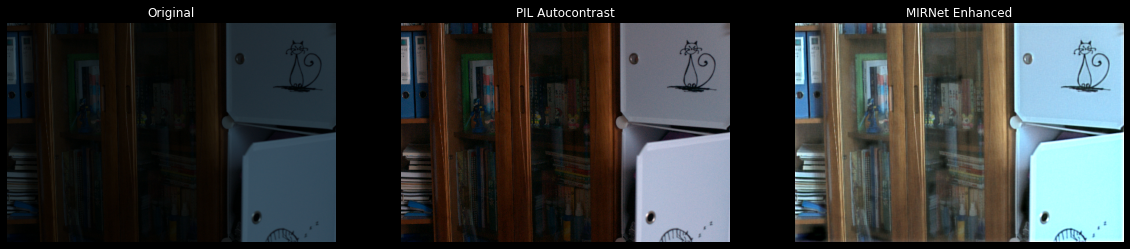

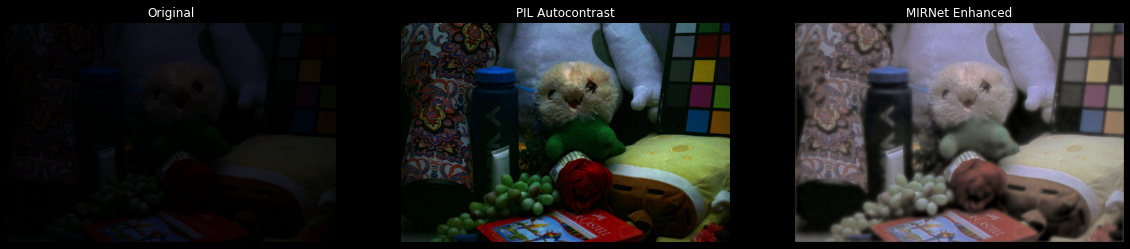

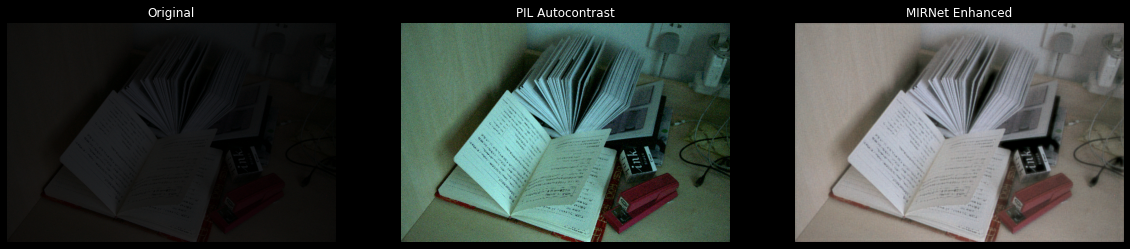

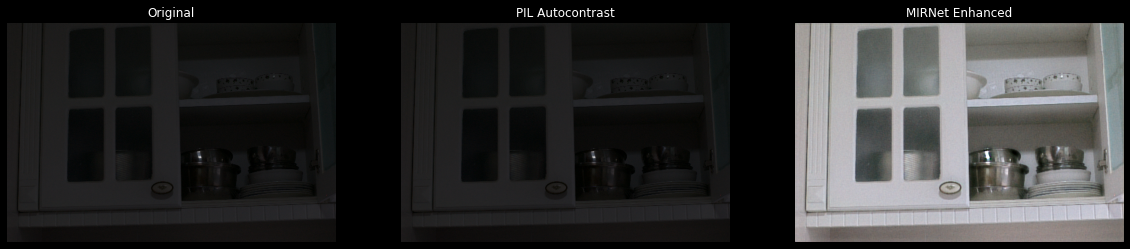

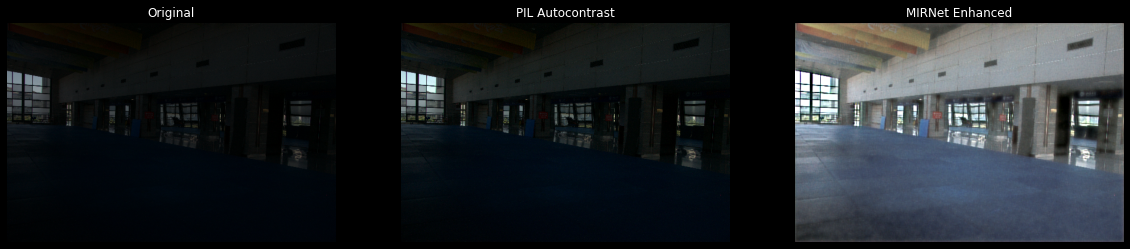

In [14]:

for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (20, 12),
    )

In [15]:
model.save("models/mirnet_model_Regularised_MIRNET_epochs"+"_"+str(num_epochs)+"_"+str(MAX_TRAIN_IMAGES)+".h5")

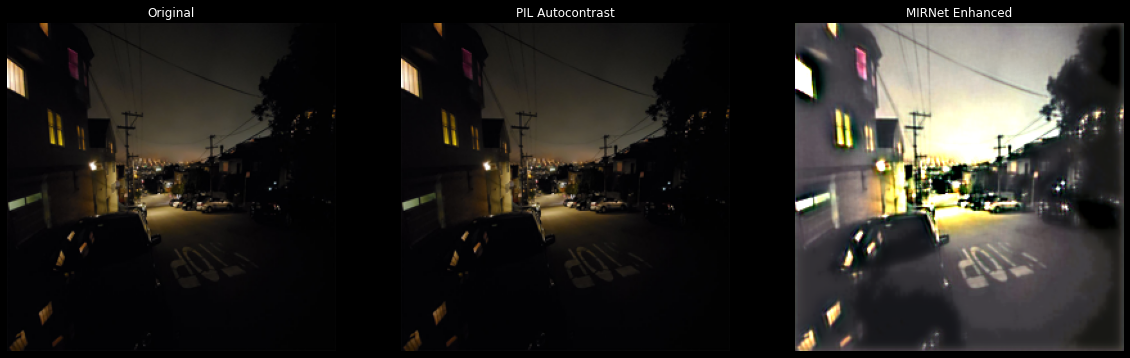

In [18]:
original_image = Image.open("test2.jpg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)

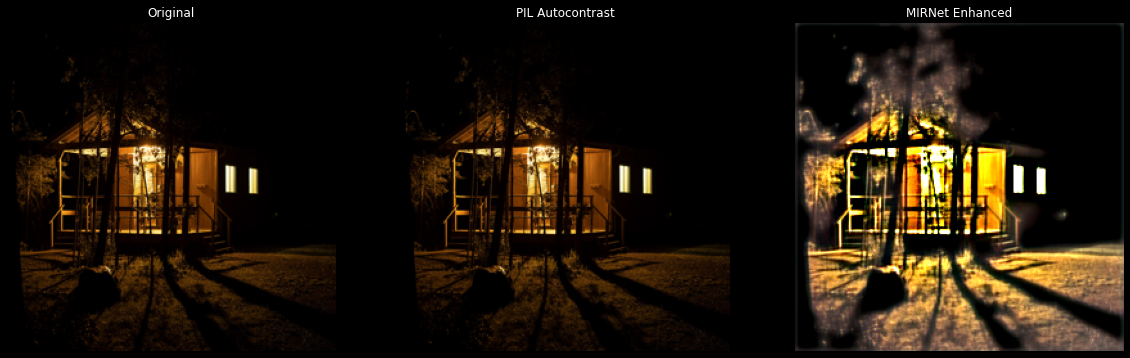

In [19]:
original_image = Image.open("test.jpg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)

## Results on our test images

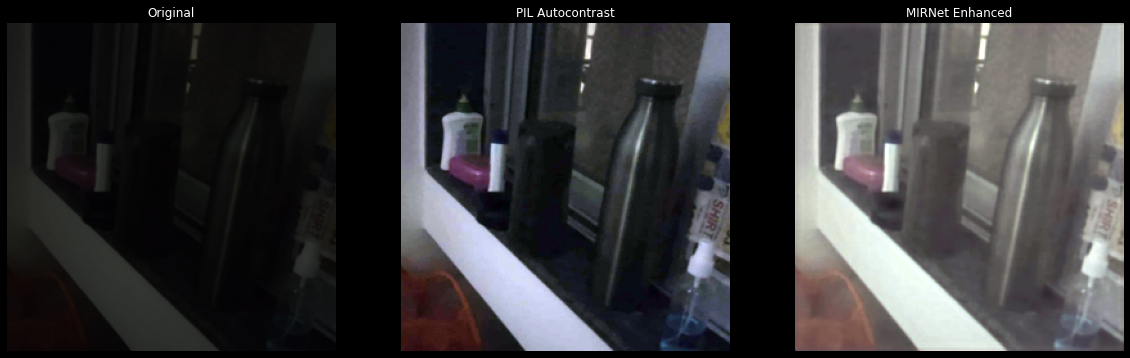

In [20]:
original_image = Image.open("Test_images\\1.jpeg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)

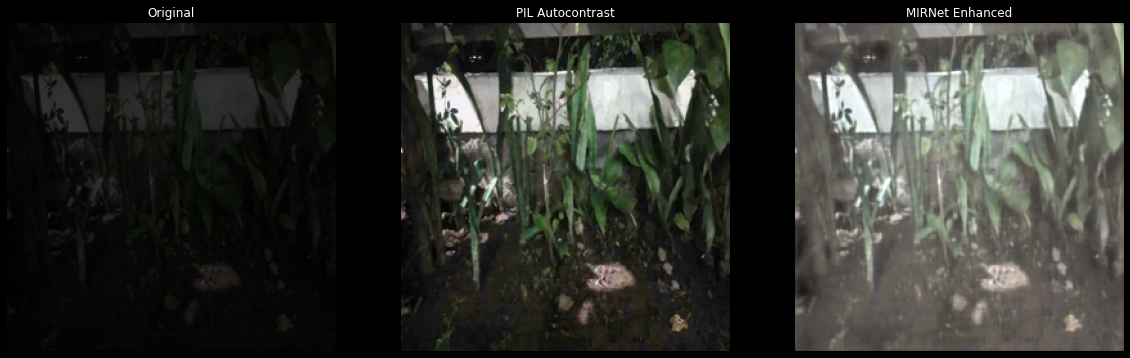

In [21]:
original_image = Image.open("Test_images\\2.jpeg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)

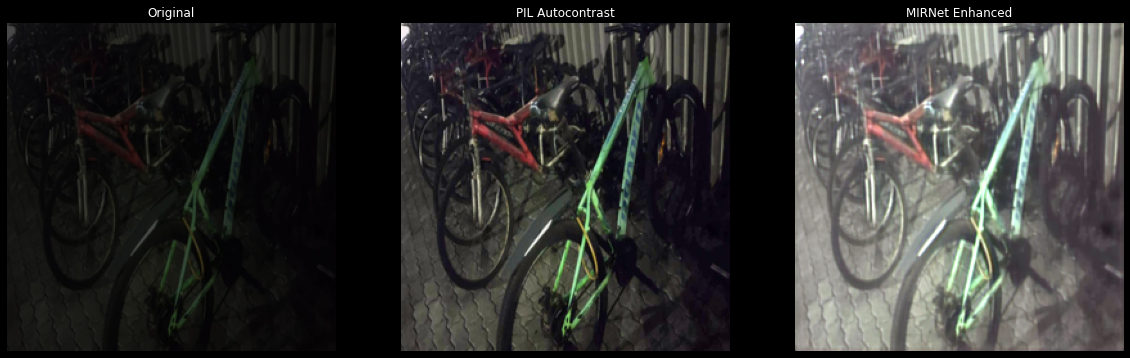

In [22]:
original_image = Image.open("Test_images\\3.jpeg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)

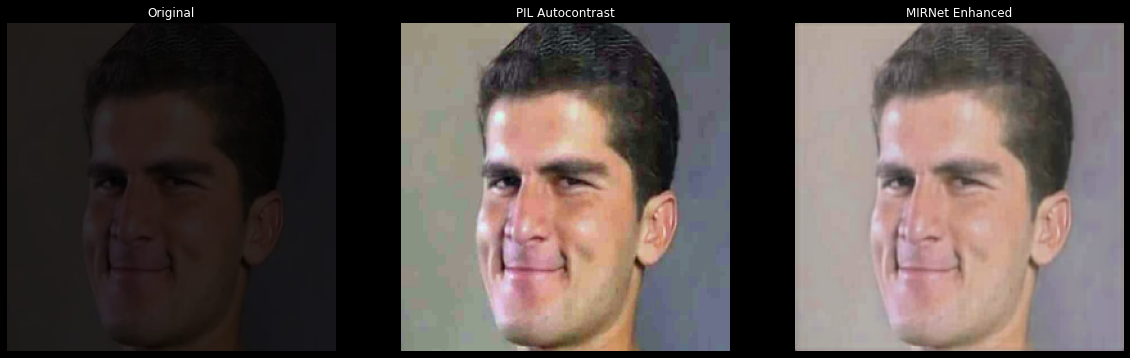

In [23]:
original_image = Image.open("Test_images\\4.jpeg")
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)